<a href="https://colab.research.google.com/github/bnsreenu/python_for_microscopists/blob/master/330_Detectron2_Instance_3D_EM_Platelet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://youtu.be/cEgF0YknpZw

## Train custom instance segmentation model using Detectron2 - on your own dataset

Create your own dataset by annotating for object detection using your favorite annotation software that can export annotations as COCO JSON format. I have used https://www.makesense.ai/ for my tutorial. I used the polygon tool to annotate objects and exported annotations as, "Single file in COCO JSON format"

**Install Detectron2**

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# # Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# # See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [3]:
# prompt: unzip the zip file

!unzip /content/drive/My\ Drive/final_pannuke_dataset.zip -d /content/data


Streaming output truncated to the last 5000 lines.
  inflating: /content/data/final_pannuke_dataset/fold2_train_output/image_1027.jpg  
  inflating: /content/data/final_pannuke_dataset/fold2_train_output/image_1028.jpg  
  inflating: /content/data/final_pannuke_dataset/fold2_train_output/image_1029.jpg  
  inflating: /content/data/final_pannuke_dataset/fold2_train_output/image_103.jpg  
  inflating: /content/data/final_pannuke_dataset/fold2_train_output/image_1030.jpg  
  inflating: /content/data/final_pannuke_dataset/fold2_train_output/image_1031.jpg  
  inflating: /content/data/final_pannuke_dataset/fold2_train_output/image_1032.jpg  
  inflating: /content/data/final_pannuke_dataset/fold2_train_output/image_1033.jpg  
  inflating: /content/data/final_pannuke_dataset/fold2_train_output/image_1034.jpg  
  inflating: /content/data/final_pannuke_dataset/fold2_train_output/image_1035.jpg  
  inflating: /content/data/final_pannuke_dataset/fold2_train_output/image_1037.jpg  
  inflating: /c

In [4]:
pip install 'git+https://github.com/facebookresearch/detectron2.git@5aeb252b194b93dc2879b4ac34bc51a31b5aee13'


  Cloning https://github.com/facebookresearch/detectron2.git (to revision 5aeb252b194b93dc2879b4ac34bc51a31b5aee13) to /tmp/pip-req-build-8la_fba2
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-8la_fba2
  Running command git rev-parse -q --verify 'sha^5aeb252b194b93dc2879b4ac34bc51a31b5aee13'
  Running command git fetch -q https://github.com/facebookresearch/detectron2.git 5aeb252b194b93dc2879b4ac34bc51a31b5aee13
  Running command git checkout -q 5aeb252b194b93dc2879b4ac34bc51a31b5aee13
  Resolved https://github.com/facebookresearch/detectron2.git to commit 5aeb252b194b93dc2879b4ac34bc51a31b5aee13
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 29.8 MB/s eta 0:00:00
  Installing build dependencies ...

In [5]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.2 ; cuda:  cu121
detectron2: 0.6


In [6]:
from detectron2.utils.visualizer import ColorMode
import matplotlib.pyplot as plt

def cv2_imshow(img):
    """
    A replacement for cv2.imshow() for displaying images in Google Colab.

    Args:
        img: A NumPy array representing an image.
    """
    # Convert BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Display the image
    plt.imshow(img_rgb)
    plt.show()


In [7]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

The default models are trained on natural images so let us go ahead and load a natural image to see if detectron is working. **We will run a pre-trained model on this image.**

In [8]:
im = cv2.imread("/content/drive/MyDrive/ColabNotebooks/data/kitchen.JPG")
cv2_imshow(im)

error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


We create a detectron2 config and a detectron2 DefaultPredictor to run inference on this image.

In [9]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_DC5_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo.  https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_DC5_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

KeyboardInterrupt: 

In [ ]:
# look at the outputs - tensors and bounding boxes.
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([72, 39, 69, 58, 39, 44, 75, 43, 45, 71, 60, 43, 45, 41, 41, 43, 58, 45,
        43, 44, 56, 47, 41, 69, 45, 70, 43, 44, 45, 39, 69, 43, 75, 39, 41, 41,
        47, 43, 58, 41, 75], device='cuda:0')
Boxes(tensor([[703.4380, 144.0455, 857.8510, 506.5736],
        [369.6783, 243.7499, 383.7241, 284.1012],
        [136.9388, 337.5629, 217.0721, 517.6235],
        [166.9899, 242.3348, 219.8243, 300.1612],
        [235.3407, 247.5448, 248.5214, 288.5075],
        [ 23.8118, 277.7756,  34.6548, 302.0351],
        [419.3823,  72.0066, 445.4690, 116.3277],
        [510.5142, 235.3142, 519.6863, 255.0639],
        [389.8859,  99.1747, 420.6154, 115.4872],
        [346.6928, 285.2446, 409.4030, 297.5113],
        [247.1815, 432.7683, 803.7862, 603.8624],
        [523.2750, 254.2419, 533.3571, 272.5920],
        [357.8499,  99.9275, 391.2559, 114.6091],
        [596.2269, 143.3925, 614.7797, 164.4311],
        [569.3777, 143.7829, 586.9908, 163.6248],
        [525.9772, 234.5415, 534.9613,

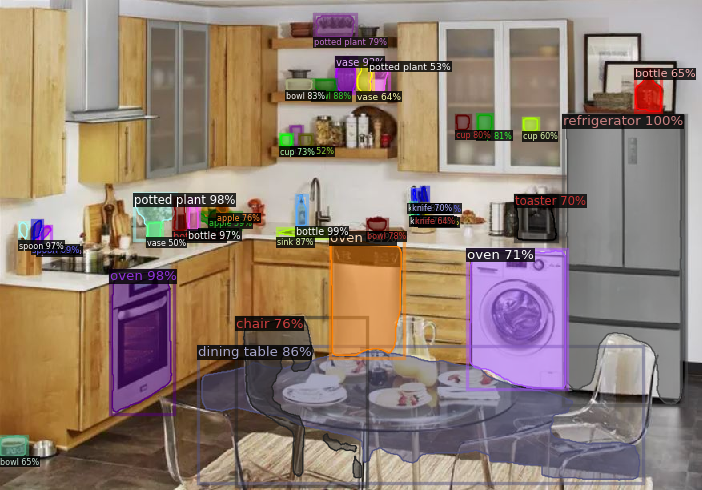

In [ ]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.8)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

Now that we know the model is working on a natural image, let us test on a scientific image.

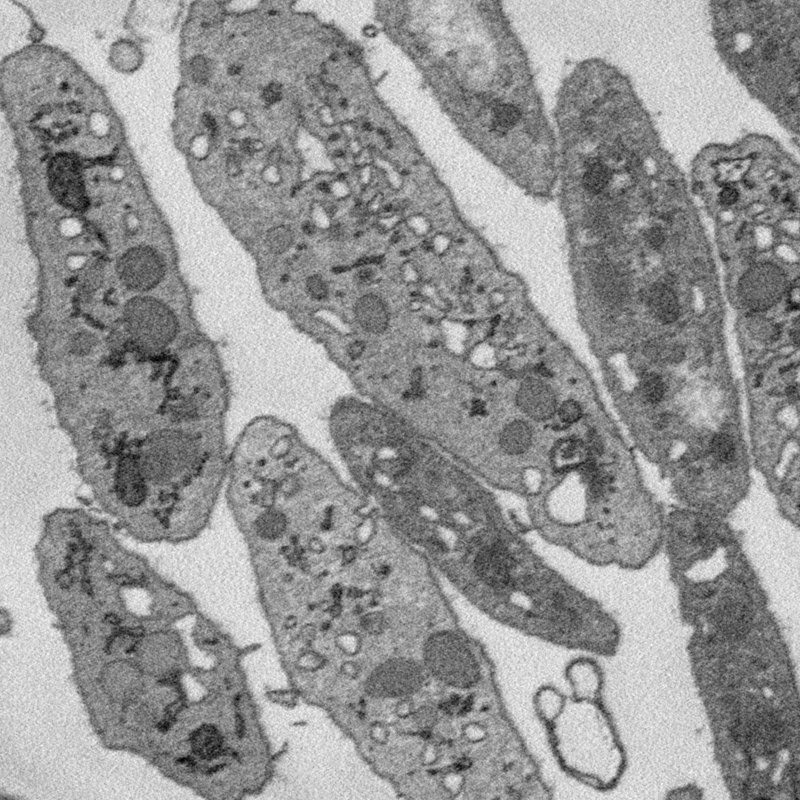

In [ ]:
sci_im = cv2.imread("/content/drive/MyDrive/ColabNotebooks/data/3D-EM-Platelet/test/3D-EM-platelet-train02.png")
cv2_imshow(sci_im)

Let us make some predictions. Remember that the model mask_rcnn_R_50_FPN_3x has no idea about our sample and did not get trained on cells or mitochondria or on any scientific images.

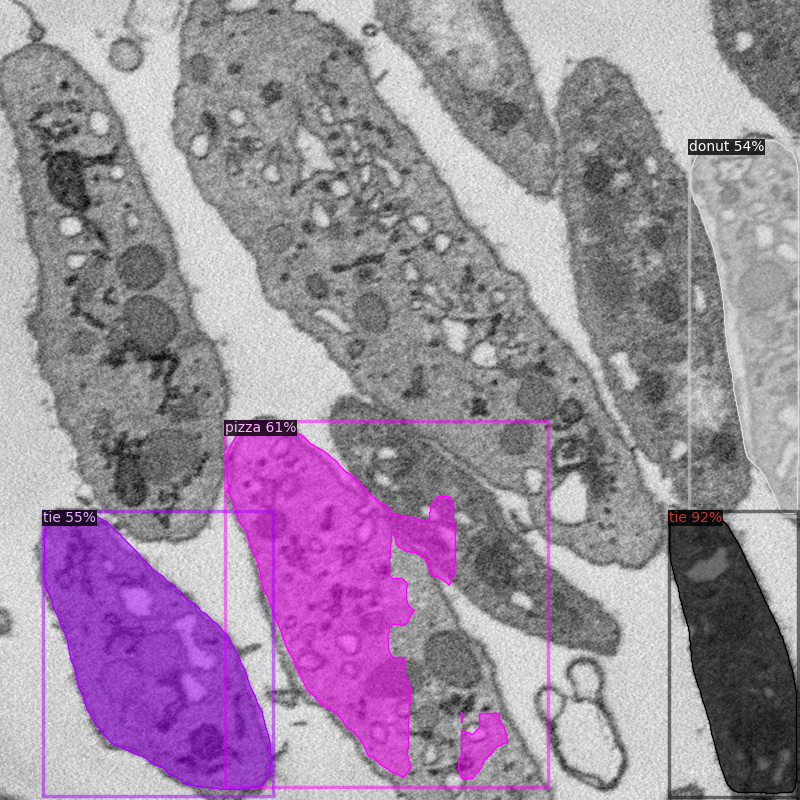

In [ ]:
sci_outputs = predictor(sci_im)
sci_v = Visualizer(sci_im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))
sci_out = sci_v.draw_instance_predictions(sci_outputs["instances"].to("cpu"))
cv2_imshow(sci_out.get_image()[:, :, ::-1])

Of course, our cells are mislabeled as Tie, Pizza, etc. Let us train on a custom dataset.

# Train on a custom dataset

Import the necessary function to register datasets in the COCO format. Let us register both the training and validation datasets. Please note that we are working with training (and validation) data that is is the coco format where we have a single JSON file that describes all the annotations from all training images. <p>
Here, we are naming our training data as 'my_dataset_train' and the validation data as 'my_dataset_val'.



In [14]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "final_pannuke_dataset/fold1_json_files/pannuke_train.json", "final_pannuke_dataset/fold1_train_output/")
register_coco_instances("my_dataset_val", {}, "final_pannuke_dataset/fold1_json_files/pannuke_val.json", "final_pannuke_dataset/fold1_val_output/")

AssertionError: Dataset 'my_dataset_train' is already registered!

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Let us extract the metadata and dataset dictionaries for both training and validation datasets. These can be used later for other purposes, like visualization, model training, evaluation, etc. We will see a visualization example right away.

In [15]:
train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")

[04/19 13:45:43 d2.data.datasets.coco]: Loaded 2032 images in COCO format from final_pannuke_dataset/fold1_json_files/pannuke_train.json


In [16]:
val_metadata = MetadataCatalog.get("my_dataset_val")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")


[04/19 13:45:51 d2.data.datasets.coco]: Loaded 508 images in COCO format from final_pannuke_dataset/fold1_json_files/pannuke_val.json


In [18]:
from matplotlib import pyplot as plt

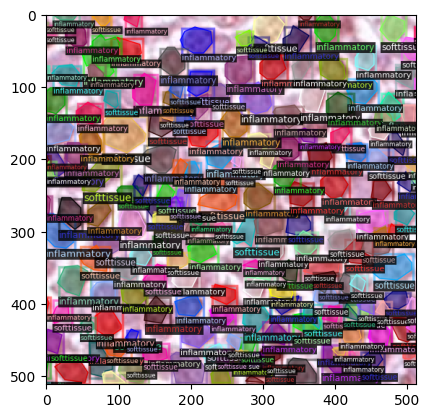

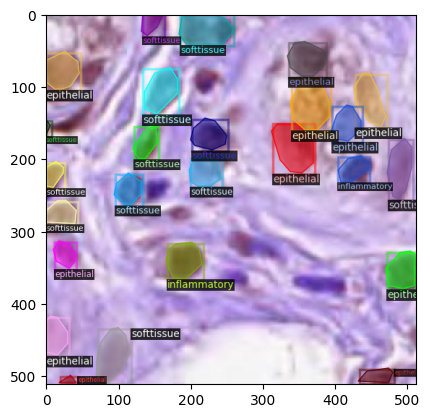

In [17]:
# Visualize some random samples
for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=2.0)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

# Train

Now we are ready to train a Mask R-CNN model using the Detectron2 library. We start by setting up a configuration file (.cfg) for the model. The configuration file contains many details including the output directory path, training dataset information, pre-trained weights, base learning rate, maximum number of iterations, etc.

In [19]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "Models/"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_DC5_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_DC5_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.0001  # pick a good LR
cfg.SOLVER.MAX_ITER = 5000   # 1000 iterations seems good enough for this dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # Default is 512, using 256 for this dataset.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5  # We have 5 classes.
# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available


[04/19 13:46:46 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

model_final_84107b.pkl: 690MB [00:05, 122MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


Train

In [20]:
trainer.train() #Start the training process

[04/19 13:47:04 d2.engine.train_loop]: Starting training from iteration 0


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/19 13:47:20 d2.utils.events]:  eta: 0:51:15  iter: 19  total_loss: 4.343  loss_cls: 1.728  loss_box_reg: 0.7327  loss_mask: 0.6917  loss_rpn_cls: 1.15  loss_rpn_loc: 0.07101    time: 0.6181  last_time: 0.6182  data_time: 0.0153  last_data_time: 0.0054   lr: 1.9981e-06  max_mem: 3856M
[04/19 13:47:36 d2.utils.events]:  eta: 0:50:44  iter: 39  total_loss: 4.188  loss_cls: 1.651  loss_box_reg: 0.7071  loss_mask: 0.6908  loss_rpn_cls: 1.05  loss_rpn_loc: 0.07483    time: 0.6202  last_time: 0.6091  data_time: 0.0086  last_data_time: 0.0059   lr: 3.9961e-06  max_mem: 3856M
[04/19 13:47:49 d2.utils.events]:  eta: 0:50:54  iter: 59  total_loss: 4.044  loss_cls: 1.531  loss_box_reg: 0.7851  loss_mask: 0.6893  loss_rpn_cls: 0.9442  loss_rpn_loc: 0.09277    time: 0.6295  last_time: 0.6179  data_time: 0.0115  last_data_time: 0.0062   lr: 5.9941e-06  max_mem: 3859M
[04/19 13:48:01 d2.utils.events]:  eta: 0:50:40  iter: 79  total_loss: 3.502  loss_cls: 1.41  loss_box_reg: 0.8084  loss_mask: 0.68

Save the config file, for potential future use

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [21]:
import yaml
# Save the configuration to a config.yaml file
# Save the configuration to a config.yaml file
config_yaml_path = "Models/config_5000_iter.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

# Inference & evaluation using the trained model

In [22]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[04/19 14:46:28 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from Models/model_final.pth ...


Verify segmentation on random validation images

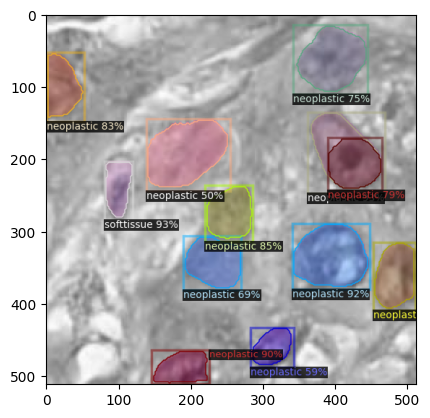

In [24]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(val_dataset_dicts, 1):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=2.0,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

Check average precision and recall. (Need more validation data than just 2 images with handful of annotations)

In [25]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_val", output_dir="output")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[04/19 14:47:10 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[04/19 14:47:10 d2.data.datasets.coco]: Loaded 508 images in COCO format from final_pannuke_dataset/fold1_json_files/pannuke_val.json
[04/19 14:47:10 d2.data.build]: Distribution of instances among all 5 categories:
|  category  | #instances   |   category   | #instances   |  category  | #instances   |
|:----------:|:-------------|:------------:|:-------------|:----------:|:-------------|
| neoplastic | 5104         | inflammatory | 2146         | softtissue | 3068         |
|    dead    | 159          |  epithelial  | 1849         |            |              |
|   total    | 12326        |              |              |            |              |
[04/19 14:47:10 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/19 14:47:10 d2.data.common]: Serializing the dat

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[04/19 14:47:13 d2.evaluation.evaluator]: Inference done 11/508. Dataloading: 0.0058 s/iter. Inference: 0.1764 s/iter. Eval: 0.0061 s/iter. Total: 0.1882 s/iter. ETA=0:01:33
[04/19 14:47:18 d2.evaluation.evaluator]: Inference done 39/508. Dataloading: 0.0027 s/iter. Inference: 0.1764 s/iter. Eval: 0.0038 s/iter. Total: 0.1830 s/iter. ETA=0:01:25
[04/19 14:47:23 d2.evaluation.evaluator]: Inference done 67/508. Dataloading: 0.0025 s/iter. Inference: 0.1774 s/iter. Eval: 0.0036 s/iter. Total: 0.1837 s/iter. ETA=0:01:21
[04/19 14:47:28 d2.evaluation.evaluator]: Inference done 94/508. Dataloading: 0.0033 s/iter. Inference: 0.1778 s/iter. Eval: 0.0038 s/iter. Total: 0.1850 s/iter. ETA=0:01:16
[04/19 14:47:33 d2.evaluation.evaluator]: Inference done 121/508. Dataloading: 0.0029 s/iter. Inference: 0.1787 s/iter. Eval: 0.0036 s/iter. Total: 0.1854 s/iter. ETA=0:01:11
[04/19 14:47:38 d2.evaluation.evaluator]: Inference done 148/508. Dataloading: 0.0031 s/iter. Inference: 0.1796 s/iter. Eval: 0.0

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[04/19 14:48:46 d2.evaluation.evaluator]: Total inference time: 0:01:34.269522 (0.187415 s / iter per device, on 1 devices)
[04/19 14:48:46 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:30 (0.179803 s / iter per device, on 1 devices)
[04/19 14:48:46 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/19 14:48:46 d2.evaluation.coco_evaluation]: Saving results to output/coco_instances_results.json
[04/19 14:48:46 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.89s).
Accumulating evaluation results...
DONE (t=0.23s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.156
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.253
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.173
 Average P

**Load a new image and segment it.**

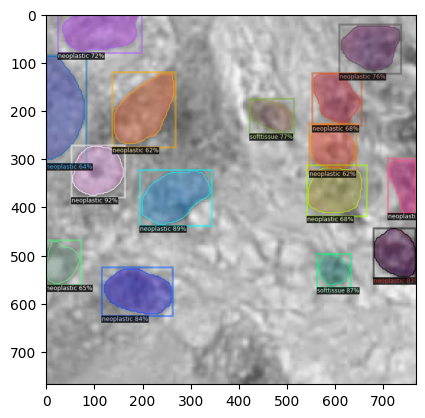

In [26]:
new_im = cv2.imread("final_pannuke_dataset/fold1_val_output/image_10.jpg")
outputs  = predictor(new_im)
v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata,instance_mode=ColorMode.IMAGE_BW,scale=3.0)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

**Process multiple images in a directory and save the results in an output directory**

In [27]:
# Directory path to the input images folder
input_images_directory = "final_pannuke_dataset/fold1_val_output/"

# Output directory where the segmented images will be saved
output_directory = "test_results"  # Replace this with the path to your desired output directory
# Loop over the images in the input folder
for image_filename in os.listdir(input_images_directory):
    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)

    # Perform prediction on the new image
    outputs = predictor(new_im)  # Format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

    # We can use `Visualizer` to draw the predictions on the image.
    v = Visualizer(new_im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=2.0,
                   instance_mode=ColorMode.IMAGE_BW)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Create the output filename with _result extension
    result_filename = os.path.splitext(image_filename)[0] + "_result.png"
    output_path = os.path.join(output_directory, result_filename)

    # Save the segmented image
    cv2.imwrite(output_path, out.get_image()[:, :, ::-1])

print("Segmentation of all images completed.")

Segmentation of all images completed.



**Segment images and save object level information into a csv file.**




In [28]:
import csv
from skimage.measure import regionprops, label

# Assuming you have already defined the 'predictor' object and loaded the model.
# Also, make sure 'metadata' is defined appropriately.

# Directory path to the input images folder
input_images_directory = "final_pannuke_dataset/fold1_val_output"

# Output directory where the CSV file will be saved
output_csv_path = "test_results/output_objects.csv"  # Replace this with the path to your desired output CSV file

# Open the CSV file for writing
with open(output_csv_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)

    # Write the header row in the CSV file
    csvwriter.writerow(["File Name", "Class Name", "Object Number", "Area", "Centroid", "BoundingBox"])  # Add more columns as needed for other properties

    # Loop over the images in the input folder
    for image_filename in os.listdir(input_images_directory):
        image_path = os.path.join(input_images_directory, image_filename)
        new_im = cv2.imread(image_path)

        # Perform prediction on the new image
        outputs = predictor(new_im)  # Format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

        # Convert the predicted mask to a binary mask
        mask = outputs["instances"].pred_masks.to("cpu").numpy().astype(bool)

        # Get the predicted class labels
        class_labels = outputs["instances"].pred_classes.to("cpu").numpy()

        # Debugging: print class_labels and metadata.thing_classes
        #print("Class Labels:", class_labels)
        #print("Thing Classes:", train_metadata.thing_classes)

        # Use skimage.measure.regionprops to calculate object parameters
        labeled_mask = label(mask)
        if len(labeled_mask)==0:
          continue
        props = regionprops(labeled_mask)

        # Write the object-level information to the CSV file
        for i, prop in enumerate(props):
            object_number = i + 1  # Object number starts from 1
            area = prop.area
            centroid = prop.centroid
            bounding_box = prop.bbox

            # Check if the corresponding class label exists
            if i < len(class_labels):
                class_label = class_labels[i]
                class_name = train_metadata.thing_classes[class_label]
            else:
                # If class label is not available (should not happen), use 'Unknown' as class name
                class_name = 'Unknown'

            # Write the object-level information to the CSV file
            csvwriter.writerow([image_filename, class_name, object_number, area, centroid, bounding_box])  # Add more columns as needed for other properties

print("Object-level information saved to CSV file.")


Object-level information saved to CSV file.


In [30]:
pip install scikit-image

NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

**Generate plots to understand the objects**

<ipython-input-29-9dc08032f529>:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Class Name", y="Object Number", data=avg_objects_per_class, ci=None, order=class_names, palette=custom_palette)
<ipython-input-29-9dc08032f529>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Class Name", y="Object Number", data=avg_objects_per_class, ci=None, order=class_names, palette=custom_palette)


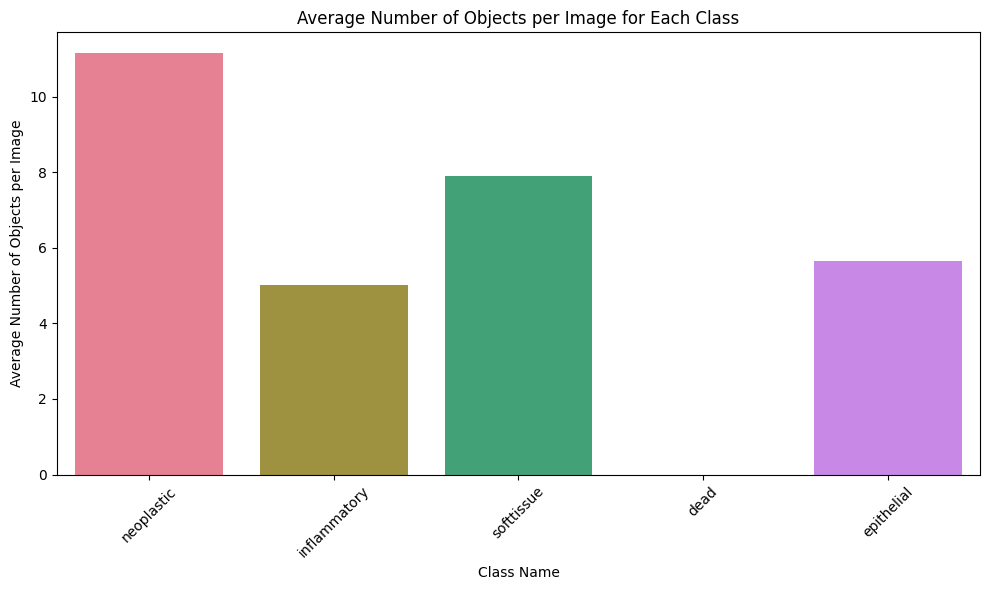

<ipython-input-29-9dc08032f529>:40: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Class Name", y="Area", data=avg_area_per_class, ci=None, order=class_names,palette=custom_palette)
<ipython-input-29-9dc08032f529>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Class Name", y="Area", data=avg_area_per_class, ci=None, order=class_names,palette=custom_palette)


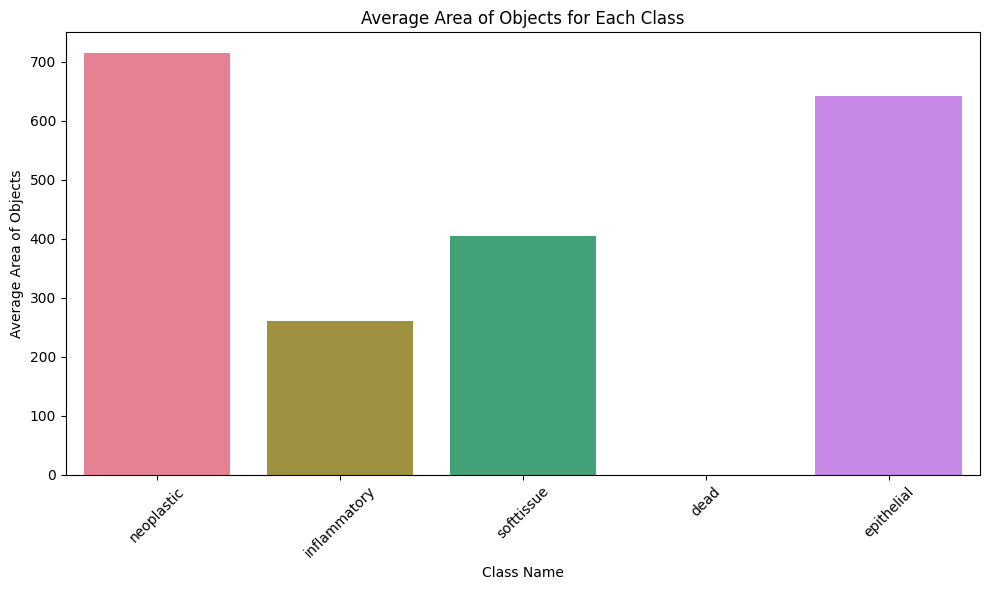

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Path to the CSV file containing the object-level information
csv_file_path = "test_results/output_objects.csv"  # Update with your CSV file path

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path)

# Get class names from train_metadata.thing_classes
class_names = train_metadata.thing_classes

# Group the data by both "File Name" and "Class Name" and calculate the average number of objects per image for each class
# first group the data by both "File Name" and "Class Name" and count the number of objects within each group.
#Then, group the data by "Class Name" only and calculate the mean of the counts, which gives us the average number of objects per image for each class.
avg_objects_per_class = df.groupby(["File Name", "Class Name"])["Object Number"].count().reset_index()
avg_objects_per_class = avg_objects_per_class.groupby("Class Name")["Object Number"].mean().reset_index()

# import seaborn as sns

# Define a custom color palette
custom_palette = sns.color_palette("husl", len(class_names))  # Choose any color palette you prefer

# Plot: Average number of objects per image for each class
plt.figure(figsize=(10, 6))
sns.barplot(x="Class Name", y="Object Number", data=avg_objects_per_class, ci=None, order=class_names, palette=custom_palette)
plt.xticks(rotation=45)
plt.xlabel("Class Name")
plt.ylabel("Average Number of Objects per Image")
plt.title("Average Number of Objects per Image for Each Class")
plt.tight_layout()
plt.show()

# Group the data by class and calculate the average area of objects for each class
avg_area_per_class = df.groupby("Class Name")["Area"].mean().reset_index()

# Plot: Average area of objects for each class
plt.figure(figsize=(10, 6))
sns.barplot(x="Class Name", y="Area", data=avg_area_per_class, ci=None, order=class_names,palette=custom_palette)
plt.xticks(rotation=45)
plt.xlabel("Class Name")
plt.ylabel("Average Area of Objects")
plt.title("Average Area of Objects for Each Class")
plt.tight_layout()
plt.show()




**Saving binary (actually multinary) images for each class for further processing.** Here, for each input image we will save n images corresponding to the number of classes. In our example, we will save 4 images for each image corresponding to the 4 classes. Each of these images will contain objects numbered 1, 2, 3, etc. - basically instance segmentation like images. These images can be used for further downstream processing.

In [31]:
import os
import cv2
import numpy as np
import torch
from detectron2.utils.visualizer import Visualizer

# Directory path to the input images folder
input_images_directory = "final_pannuke_dataset/fold1_val_output"

# Output directory where the segmented images will be saved
output_directory = "test_results_instance"  # Replace this with the path to your desired output directory

# Loop over the images in the input folder
for image_filename in os.listdir(input_images_directory):
    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)

    # Perform prediction on the new image
    outputs = predictor(new_im)  # Format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

    # Create a dictionary to store the mask for each class with unique integer labels
    class_masks = {class_name: torch.zeros_like(outputs["instances"].pred_masks[0], dtype=torch.uint8, device=torch.device("cuda:0"))
                   for class_name in train_metadata.thing_classes}

    # Assign a unique integer label to each object in the mask
    for i, pred_class in enumerate(outputs["instances"].pred_classes):
        class_name = train_metadata.thing_classes[pred_class]
        class_masks[class_name] = torch.where(outputs["instances"].pred_masks[i].to(device=torch.device("cuda:0")),
                                              i + 1,
                                              class_masks[class_name])

    # Save the masks for each class with unique integer labels
    for class_name, class_mask in class_masks.items():
        # Convert the tensor to a NumPy array and then to a regular (CPU) array
        class_mask_np = class_mask.cpu().numpy()

        # Create the output filename with _class_name_result.png extension
        class_filename = os.path.splitext(image_filename)[0] + f"_{class_name}_result.png"
        class_output_path = os.path.join(output_directory, class_filename)

        # Save the image with unique integer labels
        cv2.imwrite(class_output_path, class_mask_np.astype(np.uint8))

print("Segmentation of all images completed.")


Segmentation of all images completed.


In [39]:
# prompt: zip the folder

!zip -r /content/drive/MyDrive/ColabNotebooks/data/Models.zip /content/Models


NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

In [36]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

'en_US.UTF-8'

# END

**Interested in panoptic segmentation?**

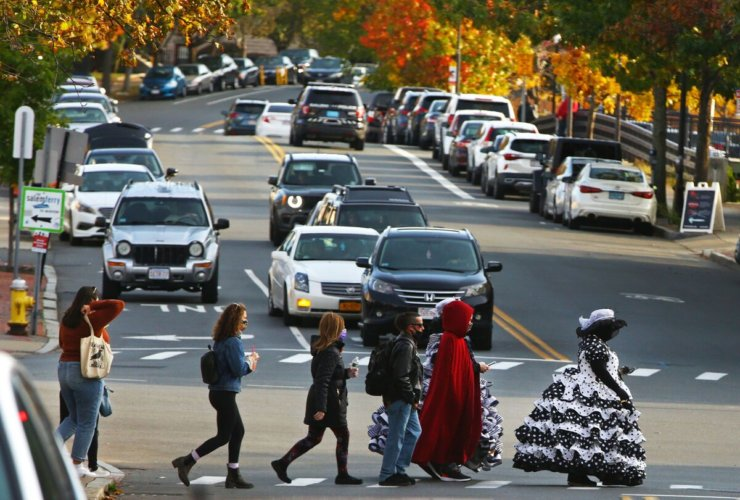

In [ ]:
my_new_image = cv2.imread("/content/drive/MyDrive/ColabNotebooks/data/street_small.jpg")
cv2_imshow(my_new_image)

[08/01 17:27:18 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


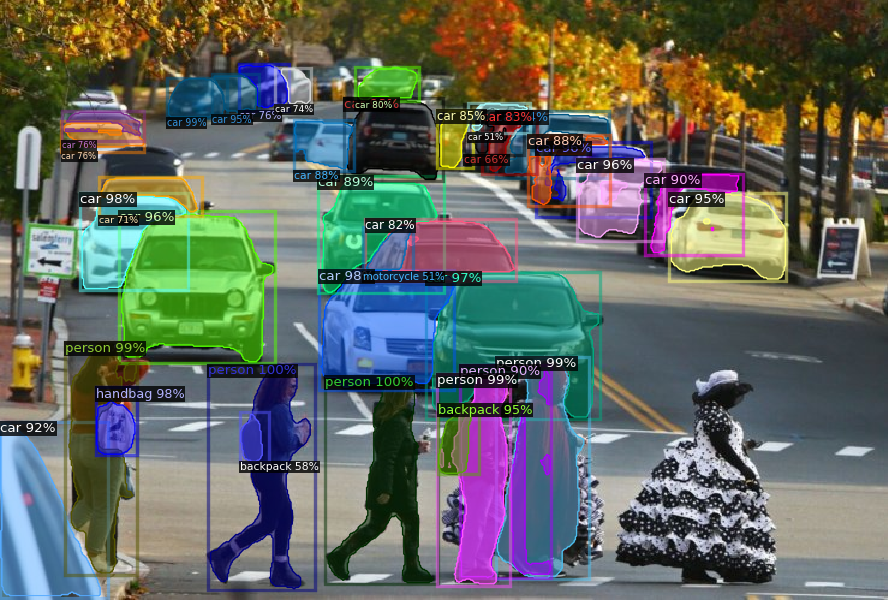

In [ ]:
# Inference with instance segmentation
cfg_inst = get_cfg()
cfg_inst.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg_inst.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo.  https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md
cfg_inst.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg_inst)
outputs = predictor(my_new_image)

v = Visualizer(my_new_image[:, :, ::-1], MetadataCatalog.get(cfg_inst.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

**Panoptic segmentation = Instance segmentation + Semantic Segmentation**





In [ ]:
# Inference with a panoptic segmentation model
cfg_pan = get_cfg()
cfg_pan.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg_pan.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg_pan)
panoptic_seg, segments_info = predictor(my_new_image)["panoptic_seg"]
v = Visualizer(my_new_image[:, :, ::-1], MetadataCatalog.get(cfg_pan.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(out.get_image()[:, :, ::-1])

[04/18 17:32:31 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl ...


model_final_cafdb1.pkl: 261MB [00:00, 299MB/s]                            

Successfully downloaded /home/studio-lab-user/.torch/iopath_cache/detectron2/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl. 260581693 bytes.
URL https://dl.fbaipublicfiles.com/detectron2/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl cached in /home/studio-lab-user/.torch/iopath_cache/detectron2/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl
[Checkpointer] Loading from /home/studio-lab-user/.torch/iopath_cache/detectron2/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl ...


Reading a file from 'Detectron2 Model Zoo'


NameError: name 'my_new_image' is not defined